In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from keras.models import Model 
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
from keras.layers import Lambda

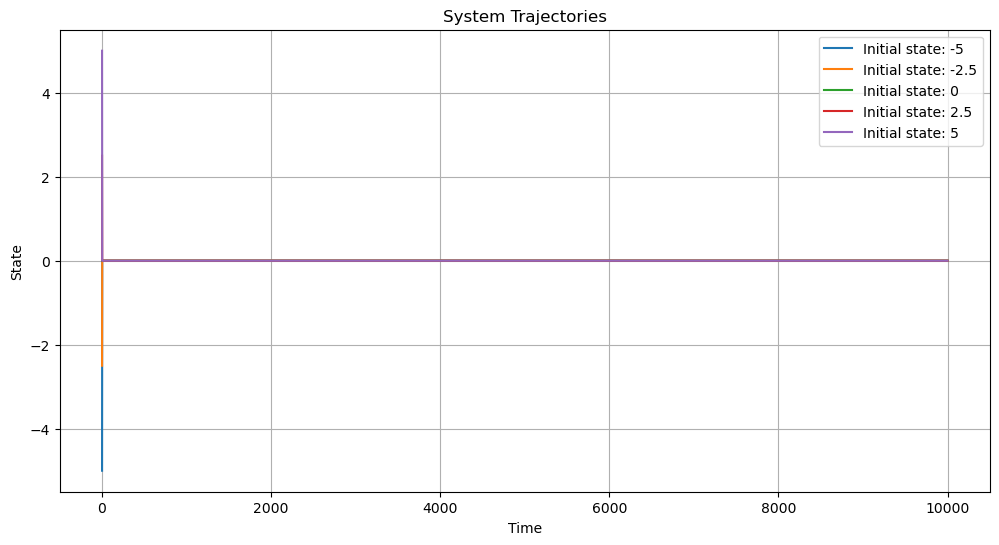

In [ ]:
def system_dynamics(x_t, u_t):
    """
    System dynamics: x_t+1 = x_t + 0.5*u_t
    """
    return x_t + 0.5 * u_t


def analytical_controller(x_t):
    """
    Analytical control law to make x_t+1 = 0
    """
    return -2 * x_t
# Training settings
epochs = 1000
history = []
n_steps = 1000
gamma = 1
x0_vals = [-5, -2.5, 0, 2.5, 5]

np.array(x0_vals)
np.random.seed(42)
time_steps = np.arange(n_steps + 1)

x_history = np.zeros((len(x0_vals), n_steps + 1))
u_history = np.zeros((len(x0_vals), n_steps))

for i, x0 in enumerate(x0_vals):
    x_history[i, 0] = x0
    for t in range(n_steps):
        u_t = analytical_controller(x_history[i, t])
        x_history[i, t + 1] = system_dynamics(x_history[i, t], u_t)
        u_history[i, t] = u_t


plt.figure(figsize=(12, 6))
for i in range(len(x0_vals)):
    plt.plot(time_steps, x_history[i], label=f'Initial state: {x0_vals[i]}')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('System Trajectories')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
# Actor
actor_input = Input(shape=(1,))
x = Dense(16, activation='relu')(actor_input)
raw_out = Dense(1, activation='linear')(x)
scaled_out = Lambda(lambda x: 5.0 * x)(raw_out)
actor_model = Model(inputs=actor_input, outputs=scaled_out)

# Critic
critic_input = Input(shape=(2,))
x = Dense(16, activation='relu')(critic_input)
critic_output = Dense(1, activation='linear')(x)
critic_model = Model(inputs=critic_input, outputs=critic_output)

critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [4]:
x_batch = x_history[:, :-1].reshape(-1, 1).astype(np.float32)
x_next_batch = x_history[:, 1:].reshape(-1, 1).astype(np.float32)

for epoch in range(epochs):
    # Sample a batch of states
    x_tensor = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    x_next_tensor = tf.convert_to_tensor(x_next_batch)

    with tf.GradientTape() as tape_critic:
        u_tensor = actor_model(x_tensor)
        x_u = tf.concat([x_tensor, u_tensor], axis=1)
        q_pred = critic_model(x_u)

        # Estimate target
        u_next = actor_model(x_next_tensor)
        x_next_u = tf.concat([x_next_tensor, u_next], axis=1)
        q_next = critic_model(x_next_u)
        r = -x_tensor**2 - 0.001 * u_tensor**2
        q_target = r + gamma * tf.stop_gradient(q_next)

        critic_loss = tf.reduce_mean((q_pred - q_target)**2)


    with tf.GradientTape() as tape_actor:
        u_tensor = actor_model(x_tensor)
        critic_value = critic_model(tf.concat([x_tensor, u_tensor], axis=1))
        actor_loss = -tf.reduce_mean(critic_value)

    actor_grads = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_grads, actor_model.trainable_variables))
    critic_grads = tape_critic.gradient(critic_loss, critic_model.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_grads, critic_model.trainable_variables))

    history.append(tf.reduce_mean(r).numpy())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Critic Loss: {critic_loss.numpy():.4f}, Actor Loss: {actor_loss.numpy():.4f}")
    

Epoch 10, Critic Loss: 0.0260, Actor Loss: 0.0281
Epoch 20, Critic Loss: 0.0257, Actor Loss: 0.0686
Epoch 30, Critic Loss: 0.0253, Actor Loss: 0.1179
Epoch 40, Critic Loss: 0.0248, Actor Loss: 0.1724
Epoch 50, Critic Loss: 0.0243, Actor Loss: 0.2208
Epoch 60, Critic Loss: 0.0238, Actor Loss: 0.2286
Epoch 70, Critic Loss: 0.0233, Actor Loss: 0.2056
Epoch 80, Critic Loss: 0.0240, Actor Loss: 0.1812
Epoch 90, Critic Loss: 0.0249, Actor Loss: 0.1786
Epoch 100, Critic Loss: 0.0253, Actor Loss: 0.2010
Epoch 110, Critic Loss: 0.0256, Actor Loss: 0.2386
Epoch 120, Critic Loss: 0.0256, Actor Loss: 0.2911
Epoch 130, Critic Loss: 0.0254, Actor Loss: 0.3676
Epoch 140, Critic Loss: 0.0245, Actor Loss: 0.4677
Epoch 150, Critic Loss: 0.0233, Actor Loss: 0.5794
Epoch 160, Critic Loss: 0.0222, Actor Loss: 0.6861
Epoch 170, Critic Loss: 0.0212, Actor Loss: 0.7763
Epoch 180, Critic Loss: 0.0205, Actor Loss: 0.8429
Epoch 190, Critic Loss: 0.0199, Actor Loss: 0.8757
Epoch 200, Critic Loss: 0.0197, Actor Lo

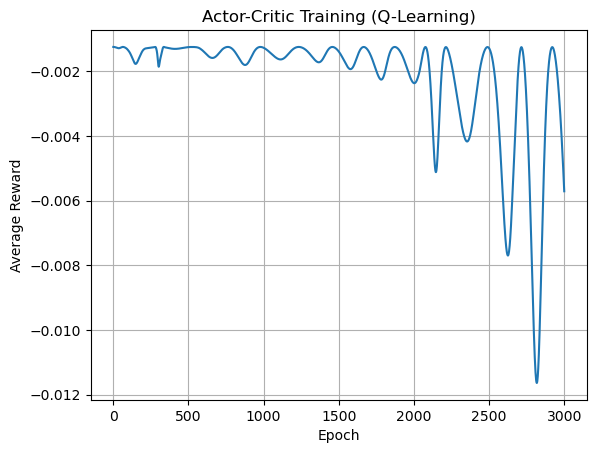

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


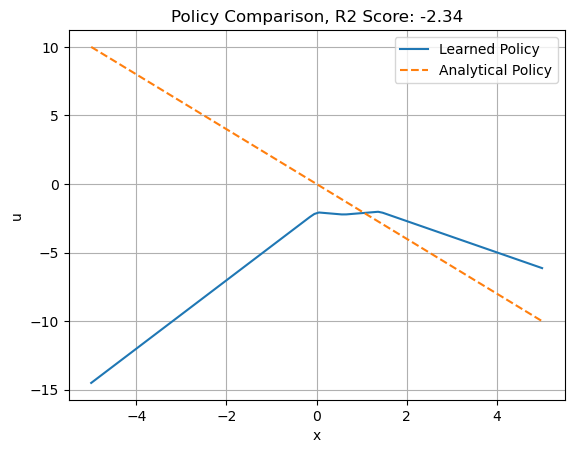

In [5]:
# Plot learning curve
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Average Reward")
plt.grid()
plt.title("Actor-Critic Training (Q-Learning)")
plt.show()

# Compare learned policy vs analytical
x_test = np.linspace(-5, 5, 100).reshape(-1, 1).astype(np.float32)
u_pred = actor_model.predict(x_test)
u_true = analytical_controller(x_test)
r2 = r2_score(u_true, u_pred)

plt.plot(x_test, u_pred, label="Learned Policy")
plt.plot(x_test, u_true, "--", label="Analytical Policy")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title("Policy Comparison, R2 Score: {:.2f}".format(r2))
plt.grid()
plt.show()